In [1]:
from fastai.vision.all import *
from fastai.vision.gan import *

In [2]:
from PIL import ImageDraw, ImageFont

In [3]:
def resize_to(img, targ_sz, use_min=False):
    w,h = img.size
    min_sz = (min if use_min else max)(w,h)
    ratio = targ_sz/min_sz
    return int(w*ratio),int(h*ratio)

In [4]:
class Crappifier():
  "Quickly draw tesxt and numbers on an image"
  def __init__(self, path_lr, path_hr):
      self.path_lr = path_lr
      self.path_hr = path_hr              
      
  def __call__(self, fn):       
      dest = self.path_lr/fn.relative_to(self.path_hr)    
      dest.parent.mkdir(parents=True, exist_ok=True)
      img = Image.open(fn)
      targ_sz = resize_to(img, 96, use_min=True)
      img = img.resize(targ_sz, resample=Image.BILINEAR).convert('RGB')
      w,h = img.size
      q = random.randint(10,70)
      ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
      img.save(dest, quality=q)

In [5]:
path = untar_data(URLs.PETS)

In [6]:
path_hr = path/'images'
path_lr = path/'crappy'

In [7]:
items = get_image_files(path_hr)

In [8]:
parallel(Crappifier(path_lr, path_hr), items);

In [9]:
bad_im = get_image_files(path_lr)

In [10]:
im1 = PILImage.create(items[0])
im2 = PILImage.create(bad_im[0])

<AxesSubplot:>

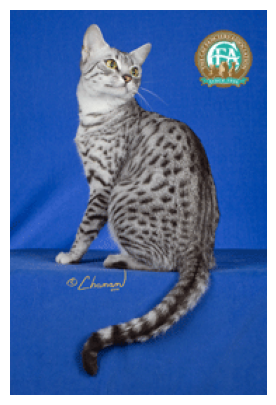

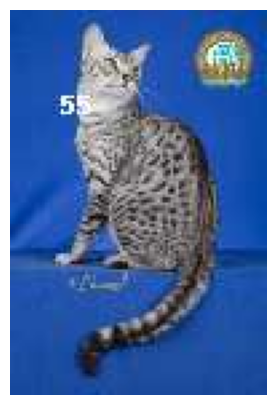

In [11]:
im1.show(); im2.show(figsize=(5,5))

In [12]:
dblock = DataBlock(
              blocks=(ImageBlock, ImageBlock),
              get_items=get_image_files,
              get_y = lambda x: path_hr/x.name,
              splitter=RandomSplitter(),
              item_tfms=Resize(224),
              batch_tfms=[*aug_transforms(max_zoom=2.), Normalize.from_stats(*imagenet_stats)]
)

In [14]:
def get_dls(bs:int, size:int):
  "Generates two `GAN` DataLoaders"
  dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   get_y = lambda x: path_hr/x.name,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(size),
                   batch_tfms=[*aug_transforms(max_zoom=2.),
                               Normalize.from_stats(*imagenet_stats)])
  dls = dblock.dataloaders(path_lr, bs=bs, path=path)
  dls.c = 3 # For 3 channel image
  return dls

In [15]:
dls_gen = get_dls(32, 128)

* The goal of this model will be to generate our "Super Resolution" images (or to make an image look better)
* On the left will be our 'crappified' image, and the right our original

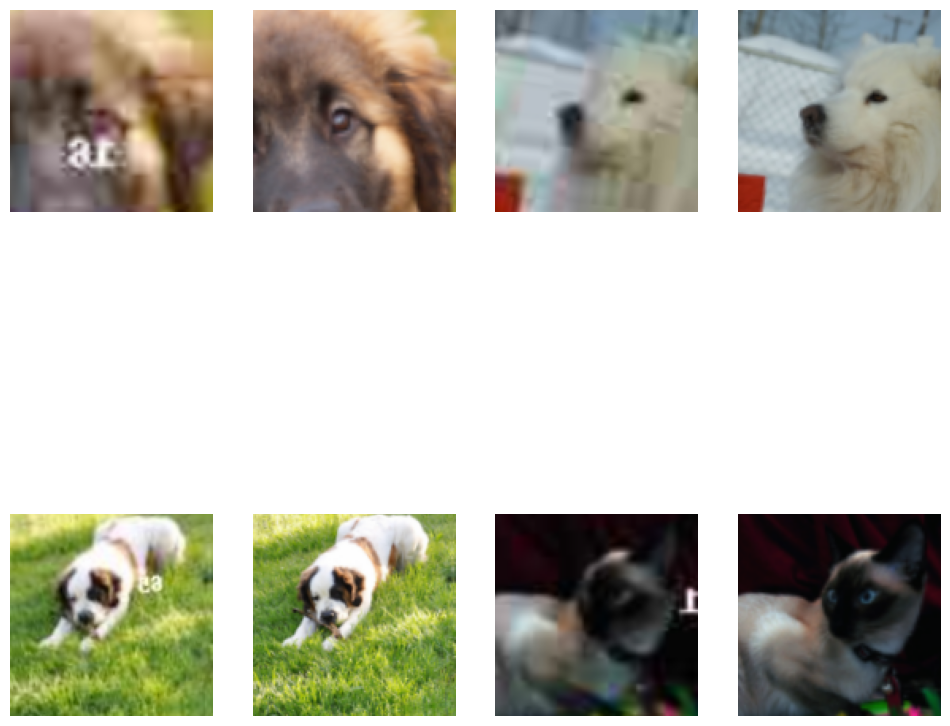

In [16]:
dls_gen.show_batch(max_n=4, figsize=(12,12))

In [17]:
wd, y_range, loss_gen = 1e-3, (-3., 3.), MSELossFlat()

In [19]:


learn_gen = unet_learner(
    dls_gen, 
    resnet34, 
    loss_func=loss_gen,
    blur=True, 
    norm_type=NormType.Weight, 
    self_attention=True,
    y_range=y_range
)

/Users/user/opt/anaconda3/envs/py37_GANs_Torch/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/Users/user/opt/anaconda3/envs/py37_GANs_Torch/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /Users/user/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


In [20]:
learn_gen.fit_one_cycle(2, pct_start=0.8, wd=wd)

epoch,train_loss,valid_loss,time


KeyboardInterrupt: 